In [1]:
import pandas as pd

In [2]:
from datetime import datetime, timedelta

In [3]:
import matplotlib
import matplotlib.pyplot as plt

In [4]:
# import dowhy
from dowhy import CausalModel

In [5]:
from IPython.display import Image, display

In [6]:
pd.set_option("mode.chained_assignment", None)

In [7]:
from futil import * 

In [8]:
wdi_df, series_df = load_wdi()

In [9]:
project_df = load_projects()
wb_df = extract_wb_projects(project_df)

For project size, to use:

* GDP at current USD, from WDI
* Multiply by % of GDP
* Compare to WB loan size

In [10]:
feature_indicators = [
    'DT.ODA.ODAT.GN.ZS',
    'NY.GDP.MKTP.CD' # divide project size at time
]

In [11]:
education_expense_indicators = [
    'SE.XPD.PRIM.ZS',
    'SE.XPD.SECO.ZS',
    'SE.XPD.TERT.ZS'
]

## Constructing time gaps

In [12]:
sector_aggs = project_df.groupby('sector').agg(
    number_projects=('ppd_project_id', 'nunique'),
    earliest_year=('start_dt', 'min'),
    latest_project=('start_dt', 'max'),
    number_donors=('donor_name', 'nunique'),
    avg_rating=('six_overall_rating', 'mean'),
    avg_duration=('project_duration', 'mean')
)

In [13]:
feature_cols = [
    'country_code', 
    'donor_name', 
    'aiddata_sectorname', 
    'six_overall_rating', 
    'start_date', 
    'completion_date', 
    'project_duration',
    'sector'
]

In [14]:
pdf = narrow_convert_project_data(project_df, feature_cols)

In [15]:
total_countries = pdf.country_code.nunique()
earliest_year = pdf.start_year.min()
latest_year = pdf.start_year.max()
year_range = range(int(earliest_year), int(latest_year))

In [18]:
calc_sector_post_year_gaps('Education', 1990)

## First approach: binary treatment, simple, education

### Assemble education indicator frame

In [19]:
# for each country-year, calculate mean growth in education indicators at year + lag

In [20]:
edu_outcome_indicators = ['SE.PRM.NENR', 'SE.PRM.CMPT.ZS', 'SE.PRM.PRSL.ZS']

In [21]:
def assemble_sectoral_df(load_persisted=True, sector_indicators=edu_outcome_indicators, persisted_lag_table=None):
    # first, assemble DF from cross product of country codes and all years
    all_countries = pdf.country_code.unique()
    df = pd.DataFrame(index = pd.MultiIndex.from_product([year_range, all_countries], names=["year", "country"])).reset_index()

    # second, look up education indicators at years + lag, after interpolating
    mdf = pd.read_csv('../data/MDGData.csv')
    edf = mdf[mdf['Indicator Code'].isin(sector_indicators)]
    tdf = edf.drop(
        columns=["Country Name", "Indicator Name", "Unnamed: 30"]
    ).melt(
        id_vars=['Country Code', 'Indicator Code'],
        var_name="Year"
    )

    tdf['Year'] = tdf['Year'].astype(int)
    
    # since this is a heavy operation, rather just reload
    if persisted_lag_table is not None:
        df = pd.read_csv(persisted_lag_table)
    
    return df, tdf

In [22]:
df, tdf = assemble_sectoral_df(persisted_lag_table='../data/transformed_data/education_df.csv')
# tdf.head()

In [23]:
# stubbing out for some later interpolation

In [24]:
ug_df = tdf[(tdf['Country Code'] == 'UGA') & (tdf['Indicator Code'] == 'SE.PRM.PRSL.ZS')]
ug_df = ug_df.set_index('Year')

<AxesSubplot:xlabel='Year'>

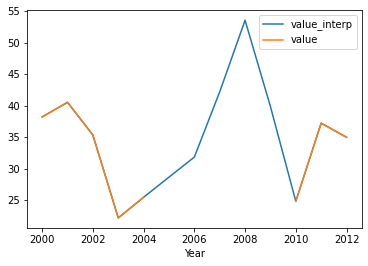

In [25]:
ug_df['value_interp'] = ug_df['value'].interpolate(method='akima')
ug_df.plot.line(y=['value_interp', 'value'])

In [26]:
# third, obtain the average; now have the response

In [27]:
def add_edu_lag_and_count(row, lag):
    lag_avg, lag_count = get_avg_indicator_with_lag(tdf, row['country'], row['year'], edu_indicators, lag)
    row['edu_lag_' + str(lag) + '_growth'] = lag_avg
    row['edu_lag_' + str(lag) + '_count'] = lag_count
    return row

In [28]:
construct_lags = False

if construct_lags:    
    for lag in range (1, 10):
        if 'edu_lag_' + str(lag) + '_growth' not in df.columns:
            df = df.apply(lambda row: add_edu_lag_and_count(row, lag), axis=1)

    prior_offset=4
    if 'edu_lag_' + str(-prior_offset) + '_growth':
        df = df.apply(lambda row: add_edu_lag_and_count(row, -4), axis=1)

In [29]:
for i in range(1, 10):
    print(f"Number of observations at lag {i} is: {df['edu_lag_' + str(i) + '_growth'].notna().sum()}")

Number of observations at lag 1 is: 930
Number of observations at lag 2 is: 917
Number of observations at lag 3 is: 904
Number of observations at lag 4 is: 902
Number of observations at lag 5 is: 849
Number of observations at lag 6 is: 801
Number of observations at lag 7 is: 747
Number of observations at lag 8 is: 707
Number of observations at lag 9 is: 664


In [30]:
# fourth, add in whether or not a project completed in that year

In [31]:
def is_project_complete_year(year, country, sp_df):
    country_proj = sp_df[sp_df['country_code'] == country].end_year.to_list()
    return year in country_proj

In [32]:
add_project_complete = False

if add_project_complete:
    eproj = pdf[pdf.sector == 'Education']
    
    if 'project_completed_year' not in df.columns:
        df['project_completed_year'] = df.apply(lambda row: is_project_complete_year(row['year'], row['country'], eproj), axis=1)

In [33]:
write_df = False

if write_df:
    df.to_csv('../data/transformed_data/education_df.csv')

In [34]:
df[df.edu_lag_4_count > 0].project_completed_year.value_counts()

False    741
True     161
Name: project_completed_year, dtype: int64

In [35]:
# remove: years within the influence of a project, i.e., during its initation and up to the lag period

In [36]:
# then: add in the various confounders, treatments, controlsc

In [37]:
# print(len(pdf))
# df[(df.edu_lag_4_count > 0) & (df.project_completed_year)].head()

In [38]:
# project_df.head()

In [39]:
def find_latest_govt_rating(country, year):
    country_proj = project_df[
        (project_df['country_code'] == country) 
        & (project_df['start_year'] <= year)
        & (project_df['wb_government_partner_rating'].notna())]
    if len(country_proj) == 0:
        return np.nan
    else:
        proj_year = country_proj[country_proj.start_year == country_proj.start_year.max()]
        return proj_year['wb_government_partner_rating'].sort_values(ascending=False).iloc[0]
    
#     return country_proj[['start_year', 'wb_government_partner_rating']]

In [40]:
if 'most_recent_govt_rating' not in df:
    df['most_recent_govt_rating'] = df.apply(lambda row: find_latest_govt_rating(row['country'], row['year']), axis=1)

In [41]:
df.most_recent_govt_rating.value_counts()

5.0    1655
2.0     403
4.0     306
6.0     205
3.0     156
1.0      11
Name: most_recent_govt_rating, dtype: int64

# Execute do-why

In [42]:
df['sector_delta_prior'] = df['edu_lag_-4_growth']
df['sector_delta_post'] = df['edu_lag_4_growth']

In [43]:
sectoral_effect_graph_binary = """digraph { 
    "Govt-Quality"[latent];
    project_completed_year [exposure, label="project_completed"];
    sector_delta_prior [adjusted, label="sector_outcome_growth_prior"];
    sector_delta_post [outcome, label=sector_outcome_growth_lagged];
    most_recent_govt_rating [label="WBGovtRating"];
    "Govt-Quality" -> project_completed_year;
    "Govt-Quality" -> sector_delta_prior;
    "Govt-Quality" -> most_recent_govt_rating;
    project_completed_year -> sector_delta_post;
    sector_delta_prior -> sector_delta_post;
    most_recent_govt_rating -> project_completed_year;
    }"""

In [44]:
causal_columns = ['sector_delta_prior', 'most_recent_govt_rating', 'project_completed_year', 'sector_delta_post']

In [45]:
causal_df = df[causal_columns]
pre_drop_N = len(causal_df)
causal_df = causal_df.dropna()
post_drop_N = len(causal_df)

print("N pre NA drop: ", pre_drop_N, " and post: ", post_drop_N)

N pre NA drop:  9856  and post:  418


In [46]:
causal_df.project_completed_year.value_counts()

False    315
True     103
Name: project_completed_year, dtype: int64

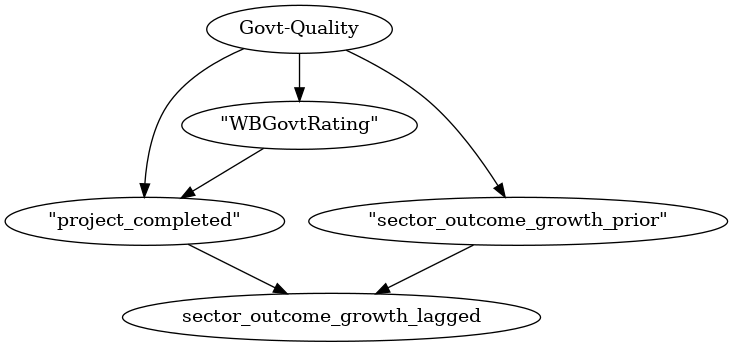

In [47]:
model = CausalModel(
    data=causal_df,
    graph=sectoral_effect_graph_binary.replace("\n", " "),
    treatment="project_completed_year",
    outcome="sector_delta_post"
)

model.view_model()
display(Image(filename="causal_model.png"))

In [48]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
─────────────────────────(Expectation(sector_delta_post|most_recent_govt_ratin
d[project_completed_year]                                                     

                      
g,sector_delta_prior))
                      
Estimand assumption 1, Unconfoundedness: If U→{project_completed_year} and U→sector_delta_post then P(sector_delta_post|project_completed_year,most_recent_govt_rating,sector_delta_prior,U) = P(sector_delta_post|project_completed_year,most_recent_govt_rating,sector_delta_prior)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [49]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression",
                                 target_units="ate", test_significance=True)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
─────────────────────────(Expectation(sector_delta_post|most_recent_govt_ratin
d[project_completed_year]                                                     

                      
g,sector_delta_prior))
                      
Estimand assumption 1, Unconfoundedness: If U→{project_completed_year} and U→sector_delta_post then P(sector_delta_post|project_completed_year,most_recent_govt_rating,sector_delta_prior,U) = P(sector_delta_post|project_completed_year,most_recent_govt_rating,sector_delta_prior)

## Realized estimand
b: sector_delta_post~project_completed_year+most_recent_govt_rating+sector_delta_prior+project_completed_year*sector_delta_prior
Target units: ate

## Estimate
Mean value: 0.012000683582670701
p-value: [0.00015782]
### Conditional Estimates
__catego

In [50]:
estimator_list = ["backdoor.propensity_score_matching", "backdoor.propensity_score_weighting", "backdoor.causalml.inference.meta.LRSRegressor"]
method_params= [ None, None, { "init_params":{} } ]

In [51]:
refuter_list = ["bootstrap_refuter", "data_subset_refuter"]

In [52]:
# for estimator, method_params in zip(estimator_list, method_params):
#     estimate = model.estimate_effect(identified_estimand, method_name=estimator, method_params=method_params)

In [53]:
refuter = model.refute_estimate(identified_estimand, estimate, method_name="bootstrap_refuter")

In [54]:
print(refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:0.012000683582670701
New effect:0.011099857563536977
p value:0.4



In [55]:
run_refuter = lambda refuter_name, refuter_params: model.refute_estimate(identified_estimand, estimate, method_name=refuter_name, **refuter_params)

In [57]:
# c_cause_refuter = model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
c_cause_refuter = run_refuter("random_common_cause", {})

In [58]:
print(c_cause_refuter)

Refute: Add a Random Common Cause
Estimated effect:0.012000683582670701
New effect:0.012189255328432846



In [59]:
placebo_refuter = run_refuter("placebo_treatment_refuter", dict(placebo_type="permuter"))

In [60]:
print(placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:0.012000683582670701
New effect:0.0003734757033073821
p value:0.49



In [61]:
sample_refuter = run_refuter("data_subset_refuter", dict(subset_fraction=0.9))

In [62]:
print(sample_refuter)

Refute: Use a subset of data
Estimated effect:0.012000683582670701
New effect:0.011998641586563729
p value:0.36



In [63]:
# Note: took a bit of digging, but the "p value" here relates to a null hypothesis that 
# the estimate obtained is part of the general set of distributions, i.e., we want this to hold
# (since it suggests that the family of estimators is not significantly affected by subsampling)

In [64]:
estimate.interpret(method_name="textual_effect_interpreter")

Increasing the treatment variable(s) [project_completed_year] from 0 to 1 causes an increase of 0.012000683582670701 in the expected value of the outcome [sector_delta_post], over the data distribution/population represented by the dataset.


In [65]:
bootstrap_refuter = run_refuter("bootstrap_refuter", {})

In [66]:
print(bootstrap_refuter)

Refute: Bootstrap Sample Dataset
Estimated effect:0.012000683582670701
New effect:0.01092908640478959
p value:0.44999999999999996



In [71]:
# cribbed for now from example notebook
dummy_args = {'num_simulations':5,'transformation_list': [('random_forest',{'n_estimators':100, 'max_depth':6})], 'true_causal_effect':(lambda x:0.5)}

In [72]:
dummy_refuter = run_refuter("dummy_outcome_refuter", dummy_args)

In [73]:
print(dummy_refuter[0])

Refute: Use a Dummy Outcome
Estimated effect:0.5
New effect:0.00538138511370847
p value:0.0



In [78]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV

In [79]:
from sklearn.preprocessing import PolynomialFeatures

In [87]:
# cribbed for now
dml_params = { 
    "init_params": { 
        'model_y':GradientBoostingRegressor(),
        'model_t': GradientBoostingRegressor(),
        "model_final":LassoCV(fit_intercept=False),
        'featurizer':PolynomialFeatures(degree=1, include_bias=True)
    },
    "fit_params": {}
}

In [88]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML", method_params=dml_params,
                                 target_units="ate", test_significance=True)
print(estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017400965493242104, tolerance: 0.0004933540925222312
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expe

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06753151364723298, tolerance: 0.0004982067479962739
A column-vector y was passed when a 1d array was expec

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0045820965256702095, tolerance: 0.0004387681701831776
A column-vector y was passed when a 1d array was exp

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035542930120842087, tolerance: 0.0004245813398420106
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was exp

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011596683995946933, tolerance: 0.00047615555107253686
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was ex

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
─────────────────────────(Expectation(sector_delta_post|most_recent_govt_ratin
d[project_completed_year]                                                     

                      
g,sector_delta_prior))
                      
Estimand assumption 1, Unconfoundedness: If U→{project_completed_year} and U→sector_delta_post then P(sector_delta_post|project_completed_year,most_recent_govt_rating,sector_delta_prior,U) = P(sector_delta_post|project_completed_year,most_recent_govt_rating,sector_delta_prior)

## Realized estimand
b: sector_delta_post~project_completed_year+most_recent_govt_rating+sector_delta_prior | sector_delta_prior
Target units: ate

## Estimate
Mean value: 0.0
Effect estimates: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.

In [89]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
─────────────────────────(Expectation(sector_delta_post|most_recent_govt_ratin
d[project_completed_year]                                                     

                      
g,sector_delta_prior))
                      
Estimand assumption 1, Unconfoundedness: If U→{project_completed_year} and U→sector_delta_post then P(sector_delta_post|project_completed_year,most_recent_govt_rating,sector_delta_prior,U) = P(sector_delta_post|project_completed_year,most_recent_govt_rating,sector_delta_prior)

## Realized estimand
b: sector_delta_post~project_completed_year+most_recent_govt_rating+sector_delta_prior | sector_delta_prior
Target units: ate

## Estimate
Mean value: 0.0
Effect estimates: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.